### This notebook should be on Watson Studio

But Watson Studio doesn't support interactive notebooks

Git Repo: https://github.ibm.com/wiotp/monitoring-dashboard


In [1]:
import csv
import requests
import collections
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [2]:
from mmfunctions import gitanalyzer

In [3]:
params = {}
params['REPO'] = 'wiotp/monitoring-dashboard'
params['REPO2'] = 'wiotp/analytics-service'
params['REPO_ID'] = 566611
params['REPO2_ID'] = 211664
params['ZENHUB_WORKSPACE'] = '5cd44ce4baded506ba8ddd5f'
params['GITHUB_TOKEN'] = 'ad7e5d3d34e79ac5d06210e74546c36b4bbc86ab'
params['ZENHUB_TOKEN'] = '814960f27921de182e39873816e4a54be9cdbb5000baa92d054e773949c1681e5e637c3bd30b54ad'
params['TRAVIS_TOKEN'] = '7B8mnG99oqNcHJgKKXMYVQ'
params['BASE_URL'] = 'https://github.ibm.com'
gitanalyzer.process_all(params)


In [4]:
# upload stuff for later use to COS
!s3cmd --access_key "cc04444c99374c9e9589b8f85e931323" --secret_key "1a5062d937b09507a05b521a41b8baf6848c0cd6936e2864" \
--access_token "icny9QB770wS9p67JHCWb6C8ySJEn_3tmfjqct9qQhSY" --host s3.eu.cloud-object-storage.appdomain.cloud --host-bucket=s3.eu.cloud-object-storage.appdomain.cloud \
put monitoring-defects.csv s3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in

upload: 'monitoring-defects.csv' -> 's3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv'  [1 of 1]
 709447 of 709447   100% in   14s    47.11 kB/s  done


In [5]:
# get it back from COS
!s3cmd --access_key "cc04444c99374c9e9589b8f85e931323" --secret_key "1a5062d937b09507a05b521a41b8baf6848c0cd6936e2864" \
--access_token "icny9QB770wS9p67JHCWb6C8ySJEn_3tmfjqct9qQhSY" --force --host s3.eu.cloud-object-storage.appdomain.cloud --host-bucket=s3.eu.cloud-object-storage.appdomain.cloud \
get s3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv wiotp-monitoring-dashboard-defects.csv

download: 's3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv' -> 'wiotp-monitoring-dashboard-defects.csv'  [1 of 1]
 709447 of 709447   100% in    2s   281.39 kB/s  done


In [6]:
defects_df = pd.read_csv('./wiotp-monitoring-dashboard-defects.csv') # parse_dates=['Created'])

## Remove the encoding prefix string
df=defects_df.replace('b\'','',regex=True).astype(object)
df=df.replace('b\"','',regex=True).astype(object)
df['Created'] = pd.to_datetime(df['Created'])
df['Updated'] = pd.to_datetime(df['Updated'])
df['Closed'] = pd.to_datetime(df['Closed'])

df = df[df['Pipeline'] != 'To Be Closed']
df.head(1)

,Title,Repo,Created,Updated,Closed,Origin,Assignee,Status,Milestone,Type,Component,BusinessValue,Severity,Risk,Theme,Blocked,Pipeline,Labels
976,"Unable to create new grains from ""create datai...",wiotp/monitoring-dashboard,2020-04-16 12:29:15,2020-04-16 12:29:48,NaT,rsiva,scottsd,open,May 2020 - Sprint 15,Bug,NaN,0,3,2,NaN,NaN,New Issues,['bug']


In [7]:
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import Layout, Button, ToggleButton, Box
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from ipywidgets import Output

#w = widgets.IntSlider()
#display(w)

In [8]:
dfs = [df[df['Severity'] == 1], df[df['Severity'] == 2], df[df['Severity'] == 3], 
       df[df['Severity'] == 4], df]

cnt = []
labels = []
explode = []
for dfs_el in dfs:
    cnt_el = dfs_el.groupby('Type')['Title'].count()
    labels.append(cnt_el.index)
    explode.append(np.zeros(cnt_el.size) + 0.02)
    cnt.append(cnt_el)
    
def f(sv):
    if sv > 10:
        fig, ax = plt.subplots(1, 5, figsize=(20,6))
        for i in [0,1,2,3,4]:
            ax[i].pie(cnt[i], explode=explode[i], labels=labels[i], autopct='%1.1f%%',
                      shadow=True, startangle=90)
    else:
        fig1, ax1 = plt.subplots()
        ax1.pie(cnt[sv], explode=explode[sv], labels=labels[sv], autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax1.set_title('Monitoring issues by type')

#plt.show()
interact(f, sv=[('sev1', 0), ('sev2', 1), ('sev3',2), ('sev4',3), ('sev1-4', 4), ('all', 11)]);

interactive(children=(Dropdown(description='sv', options=(('sev1', 0), ('sev2', 1), ('sev3', 2), ('sev4', 3), …

### Velocities

- Overall Velocity
- Defect Velocity (**implemented** - starting mid 2019)
- Customer satisfaction (**no data** not included as we have no data)
- Defect breakdown by severity (**no data** we have no severities in our defects)
- Value per sprint (**no data** value of epics or stories is not known)
- Percentage of test case coverage (**no data** - we do not track that)
- Customer Support Requests (**no data*)
- Trends (let's define what trends we need)
- NPS (**no data**)
- Build failures (need to get Travis data)
- Deployment failures (Jenkins ?)
- Technical Debts (**no data** we need a label)

In [86]:
# defect velocity since mid 2019
StartWith = '2019-06-30'


dfv = df.copy()
dfv = dfv[dfv['Status'] == 'closed']
dfv = dfv[dfv['Created'] > StartWith]
dfv['Age_in_weeks'] = dfv['Closed'] - dfv['Created'] + pd.Timestamp('2020-01-01')
dfv = dfv[['Severity', 'Age_in_weeks']]

dfvs = [dfv[dfv['Severity'] == 1], dfv[dfv['Severity'] == 2], dfv[dfv['Severity'] == 3], 
       dfv[dfv['Severity'] == 4], dfv]

IMAX = 40
emptydf = pd.DataFrame(index=np.arange(1,IMAX),columns=['Severity'])
emptydf['Severity'] = 0

cntv = []
labelsv = []
xv = []
for dfs_el in dfvs:
    cnt_el = dfs_el.groupby(dfs_el['Age_in_weeks'].dt.week).count().drop(columns='Age_in_weeks')
    imax = cnt_el.index.max()
    if np.isnan(imax):
        cnt_el = emptydf.copy()
    elif imax <= IMAX:
        # print (cnt_el)
        # print (emptydf)
        cnt_el = emptydf.copy().merge(cnt_el, how='outer', left_index = True, right_index=True)
        cnt_el['Severity'] = cnt_el['Severity_y'].fillna(cnt_el['Severity_x'])
    labelsv.append(cnt_el.index)
    xv.append(np.arange(1, cnt_el.size))
    cntv.append(cnt_el)

#print (cntv[3].index.max())
#print (cntv[0].index, cntv[0]['Age_in_weeks'].values)
# print (cntv[0].unstack(fill_value=0))
def f(sv):
    #df_vel = df_velocity.copy()
    if sv > 10:
        fig, ax = plt.subplots(1, 5, figsize=(20,3))
        for i in [0,1,2,3,4]:
            ax[i].bar(cntv[i].index, cntv[i]['Severity'].values)
    else:
        fig1, ax1 = plt.subplots(figsize=(7,3))
        ax1.bar(cntv[sv].index, cntv[sv]['Severity'].values)

interact(f, sv=[('sev1', 0), ('sev2', 1), ('sev3',2), ('sev4',3), ('sev1-4', 4), ('all', 11)]);

interactive(children=(Dropdown(description='sv', options=(('sev1', 0), ('sev2', 1), ('sev3', 2), ('sev4', 3), …

### Initiatives, Epics, Stories

- Epics per Initiatives
- Initiative completion by percentage
- Percentage of Epics completed
- Percentage of stories completed by sprint vs what was committed
- Defects per story
- End to end start to completion average

Text(0.5, 1.0, 'Open epics by business value - (0 = not yet ranked)')

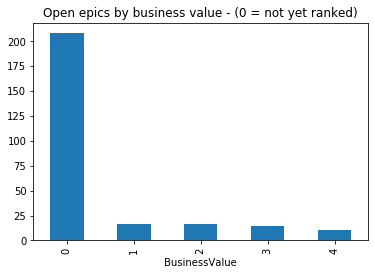

In [11]:
# defect velocity since mid 2019
StartWith = '2019-06-30'


df_value = df.copy()
df_value = df_value[df_value['Status'] == 'open']
#df_value = df_value[df_value['Type'] == 'Epic']
#df_velocity = df_velocity[df_velocity['Created'] > StartWith]
#df_velocity['Age_in_weeks'] = df_velocity['Closed'] - df_velocity['Created'] + pd.Timestamp('2020-01-01')
#df_velocity = df_velocity[['Severity', 'Age_in_weeks']]


df_vel = df_value[['BusinessValue','Risk']]
df_vel.groupby(df_vel['BusinessValue']).count().plot(figsize=(6,4), kind='bar', legend=False)
plt.title('Open epics by business value - (0 = not yet ranked)')

In [12]:
# Open vs closed epics
def f(date):
    df_epics = df[df['Type'] == 'Epic']
    if date == 1:
        StartWith = '2019-06-30'
    elif date == 2:
        StartWith = '2019-09-30'
    elif date == 3:
        StartWith = '2019-12-31'
    elif date == 4:
        StartWith = '2020-01-31'
    elif date == 5:
        StartWith = '2020-02-28'
    
    df_epics = df_epics[df_epics['Created'] > StartWith]
    df_epics = df_epics[['Status', 'Type']]
    length = 20 * df_epics.index.size / 200
    df_epics.groupby(df_epics['Status']).count().plot(figsize=(length,2), kind='barh', legend=False)
    plt.title('Epics by completion')

interact(f, date=[('Jul 2019', 1), ('Oct 2019', 2), ('Jan 2020',3), ('Feb 2020',4), ('Mar 2020', 5)]);

interactive(children=(Dropdown(description='date', options=(('Jul 2019', 1), ('Oct 2019', 2), ('Jan 2020', 3),…